# Illustration for the introduction of binarsity's paper

- Use decision_function instead of predict_proba, what's the difference ?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification, make_moons, make_circles

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.utils.validation import indexable
from sklearn.model_selection import check_cv, cross_val_score, \
    StratifiedShuffleSplit
from sklearn.metrics.scorer import check_scoring
from sklearn.model_selection._validation import _fit_and_score
from sklearn.externals.joblib import Parallel, delayed

from mlpp.preprocessing import FeaturesBinarizer
#import mlpp.base.math.build.math
#from mlpp.learner import LearnerLogReg, LearnerLogRegBinarsity
from mlpp.inference import LearnerLogReg

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

/Users/Simon/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Simon/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 1. Generation of several datasets (some are linearly separable, some are not)

In [2]:
# Columns names
columns = [c + ":continuous" for c in "AB"]

n_samples = 1000

# First dataset
rng = np.random.RandomState(2)
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                                    random_state=1, n_clusters_per_class=1)

X += 2 * rng.uniform(size=X.shape)
X = pd.DataFrame(data=X, columns=columns)
linearly_separable = (X, y)

# Second dataset
X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=0)
X = pd.DataFrame(data=X, columns=columns)
moon = (X, y)

# Third dataset
X, y = make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=1)
X = pd.DataFrame(data=X, columns=columns)
circles = (X, y)

datasets = [linearly_separable, moon, circles]

## 2. Create classifiers

In [3]:
def compute_score(clf, X, y, cv, verbose=True, fit_params=None):
    scores = cross_val_score(clf, X, y, cv=cv, verbose=0,
                             n_jobs=1, scoring="roc_auc",
                             fit_params=fit_params)
    score_mean = scores.mean()
    score_std = 2 * scores.std()
    if verbose:
        print("AUC: %0.3f (+/- %0.3f)" % (score_mean, score_std))
    return score_mean, score_std

def cross_val_score_(estimators, X, y=None, groups=None, scoring=None,
                     cv=None, n_jobs=1, verbose=0, fit_params=None):
    X, y, groups = indexable(X, y, groups)
    cv = check_cv(cv, y, classifier=True)
    cv_iter = list(cv.split(X, y, groups))

    parallel = Parallel(n_jobs=n_jobs, verbose=0)

    scores = parallel(delayed(_fit_and_score)(estimators[i], X, y,
                                              check_scoring(estimators[i],
                                                            scoring=scoring),
                                              train, test, verbose, None,
                                              fit_params)
                      for i, (train, test) in enumerate(cv_iter))

    return np.array(scores)[:, 0]


def compute_score_(clf, X, y, K, verbose=True, fit_params=None):
    scores = cross_val_score_(clf, X, y, cv=K, verbose=0,
                              n_jobs=1, scoring='roc_auc',
                              fit_params=fit_params)
    score_mean = scores.mean()
    score_std = 2 * scores.std()
    if verbose:
        print("\n AUC: %0.3f (+/- %0.3f)" % (score_mean, score_std))
    return score_mean, score_std

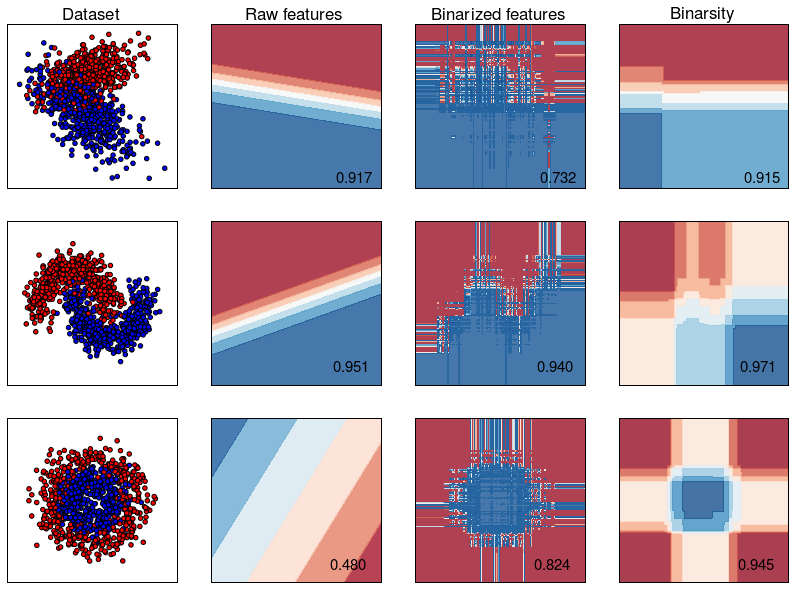

In [4]:
figure = plt.figure(figsize=(14, 10))
i = 1
h = .01  # step size in the mesh

n_rows = 3
n_cols = 4

n_cuts = 200

# iterate over datasets
for n_dataset, ds in enumerate(datasets):
    # Get features and labels
    X, y = ds

    # Cross-validation iterator, same for all methods
    cv = StratifiedKFold(y, n_folds=5, shuffle=False)

    # Just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(n_rows, n_cols, i)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright)
    if n_dataset == 0:
        ax.set_title("Dataset", fontsize=17)

    x_min, x_max = X.iloc[:, 0].min() - .5, X.iloc[:, 0].max() + .5
    y_min, y_max = X.iloc[:, 1].min() - .5, X.iloc[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())

    ######################################
    ## Logistic regression on raw features
    i += 1
    ax = plt.subplot(n_rows, n_cols, i)

    learner = LogisticRegression(C=1e10)
    learner.fit(X, y)
    score = compute_score(learner, X, y, cv, verbose=False)[0]

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].        
    X_mesh = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel()], columns=columns)
    Z = learner.predict_proba(X_mesh)[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, alpha=0.3)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if n_dataset == 0:
        ax.set_title("Raw features", fontsize=17)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score),
            size=15, horizontalalignment='right')

    ############################################
    ## Logistic regression on binarized features
    i += 1
    ax = plt.subplot(n_rows, n_cols, i)

    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    X_bin = binarizer.fit_transform(X)
    learner = LogisticRegression(C=1e10)
    learner.fit(X_bin, y)
    score = compute_score(learner, X_bin, y, cv, verbose=False)[0]

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].        
    X_mesh = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel()], columns=columns)
    X_mesh_bin = binarizer.transform(X_mesh)
    Z = learner.predict_proba(X_mesh_bin)[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, alpha=0.3)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if n_dataset == 0:
        ax.set_title("Binarized features", fontsize=17)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score),
            size=15, horizontalalignment='right')

    ################################
    ## Binarsity logistic regression
    i += 1
    ax = plt.subplot(n_rows, n_cols, i)

    binarizer = FeaturesBinarizer(n_cuts=n_cuts)
    X_bin = binarizer.fit_transform(X)
    #learner = LearnerLogRegBinarsity(binarizer.blocks_start, binarizer.blocks_length, C=1e3)
    
    blocks_start = binarizer.feature_indices[:-1, ]
    blocks_length = binarizer.n_values
    C_chosen = 1.7e2
    learner = LearnerLogReg(penalty='binarsity', solver='svrg', C=C_chosen,
                        verbose=False, step=1e-3,
                        blocks_start=blocks_start,
                        blocks_length=blocks_length)
    
    learner.fit(X_bin, y)
    #score = compute_score_(learner, X_bin, y, cv=cv, verbose=True, 
    #                      fit_params={'blocks_start': binarizer.blocks_start,
    #                                  'blocks_length': binarizer.blocks_length})[0]
    
    K = 5
    learners = [
        LearnerLogReg(penalty='binarsity', solver='svrg', C=C_chosen,
                      verbose=False, step=1e-3,
                      blocks_start=blocks_start,
                      blocks_length=blocks_length)
        for _ in range(K)]
    score = compute_score_(learners, X_bin, y, K, verbose=False)[0]
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].        
    X_mesh = pd.DataFrame(data=np.c_[xx.ravel(), yy.ravel()], columns=columns)
    X_mesh_bin = binarizer.transform(X_mesh)
    Z = learner.predict_proba(X_mesh_bin)[:, 1]
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    # ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=cm_bright, alpha=0.3)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    if n_dataset == 0:
        ax.set_title("Binarsity", fontsize=17)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score),
            size=15, horizontalalignment='right')

    i += 1
plt.savefig('binarsity_illustration.pdf', bbox_inches='tight')
plt.show()